# **Kaggle HW5: [TEAM]**



**Remember to write your team name above, which MUST match your team name on Kaggle!!** Assignments without a team name will receive a 0/40 on the "accuracy on test data" component of this assignment's grade.

### **Load the Data**

In [ ]:
# This cell is necessary only if you are running on Google Colab. It downloads the files to your
# Colab instance so you don't have to upload them here.

import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_train.csv',
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_test.csv',
          'edx_test.csv')

### **Sample Code: Random Classifier**

**NOTE**: This classifier **DOES NOT** count as one of the 2 required for this assignment! It is merely here to illstrate how to submit your predictions.

See the Kaggle assignment (Data tab) for a description of each column in the dataset. You are creating a classifier to predict whether or not a student will get certified, stored in the `"certified"` column.

In [ ]:
import pandas as pd
from sklearn.dummy import DummyClassifier

target = "certified" # target column

# This classifier returns labels sampled uniformly at random
df_train = pd.read_csv('edx_train.csv')
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(df_train.drop(target, axis=1), df_train[target])

DummyClassifier(strategy='uniform')

The code below generates predictions on the test set, and outputs the predictions into a CSV file.

In [ ]:
# Generate predictions on the test set
df_test = pd.read_csv('edx_test.csv')
predictions = dummy_model.predict(df_test)

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission.csv', index=False)

# See below for instructions on how to upload submission.csv to Kaggle,
# in order to evaluate your model and get points.

### **[5 Pts] Model Comparison**

**Instructions**: Run at least 2 different classification models. The classification models we have learned in class are: [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), and [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [Neural Networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html). For each model, try at least 2 different hyperparameter settings.

Then, make one or more visualizations that let you compare the models you trained. Sample visualizations you can make include confusion matrices, or graphs of train and validation accuracy/error. See past section and homework code for how to make these visualizations.

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
df_train.head()

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130545492,1,1,1,1,United States,Master's,1984.0,m,3/10/13,7/29/13,1161.0,50.0,NaN,12.0,0
1,HarvardX/ER22x/2013_Spring,MHxPC130536944,1,1,1,1,United Kingdom,Master's,1985.0,f,3/13/13,8/1/13,1360.0,10.0,NaN,29.0,0
2,HarvardX/CS50x/2012,MHxPC130442298,1,1,1,1,India,NaN,NaN,NaN,8/2/12,7/25/13,77.0,18.0,NaN,7.0,0
3,HarvardX/ER22x/2013_Spring,MHxPC130273564,1,1,1,1,United Kingdom,Bachelor's,1982.0,m,1/23/13,8/13/13,1425.0,29.0,NaN,34.0,0
4,HarvardX/CS50x/2012,MHxPC130247761,1,1,0,0,United States,Secondary,1989.0,m,3/5/13,3/5/13,6.0,1.0,NaN,1.0,0


In [ ]:
## Make a dataset that does not have 'userid'
df_train2 = df_train.drop('userid_DI', axis = 1)
df_test2 = df_test.drop('userid_DI', axis = 1)

# Remove 2 features
coln = list(df_train2.columns)
coln.remove('start_time_DI')
coln.remove('last_event_DI')

df_train_rm = df_train2[coln]

coln.remove('certified')
df_test_rm = df_test2[coln]

## 1. Handle the missing values

In [ ]:
df_train_rm.fillna(0, inplace=True)
df_test_rm.fillna(0, inplace=True)

numerical_values = ["YoB", "nevents", "nplay_video", "nchapters", "nforum_posts"]
for column_name in numerical_values:
  unknown_mask = df_train_rm[column_name] == -1
  column_mean = df_train_rm[~unknown_mask][column_name].mean()
  df_train_rm.loc[unknown_mask, column_name] = column_mean

<ipython-input-6-5a754514bc24>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_rm.fillna(0, inplace=True)
<ipython-input-6-5a754514bc24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_rm.fillna(0, inplace=True)


## 2. Encode categorical variables(one-hot encoding)

In [ ]:
# Perform one-hot encoding for categorical variables in the training dataset
train_data_encoded = pd.get_dummies(df_train_rm, columns=['final_cc_cname_DI', 'LoE_DI', 'gender', 'course_id'])
#trai_data_encoded = pd.get_dummies(df_train)

# Perform one-hot encoding for categorical variables in the test dataset
test_data_encoded = pd.get_dummies(df_test_rm, columns=['final_cc_cname_DI', 'LoE_DI', 'gender', 'course_id'])

# Verify the encoded datasets
print(train_data_encoded.head())
print(test_data_encoded.head())

## 3. Feature scaling

In [ ]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Perform feature scaling on numeric columns in the training dataset
numeric_columns = ['YoB', 'nevents', 'ndays_act', 'nplay_video', 'nchapters', 'nforum_posts']
train_data_scaled = train_data_encoded.copy()
train_data_scaled[numeric_columns] = scaler.fit_transform(train_data_encoded[numeric_columns])

# Perform feature scaling on numeric columns in the test dataset
test_data_scaled = test_data_encoded.copy()
test_data_scaled[numeric_columns] = scaler.transform(test_data_encoded[numeric_columns])

# Verify the scaled datasets
print(train_data_scaled.head())
print(test_data_scaled.head())

In [ ]:
# Check if data still has missing values
print(train_data_scaled.isnull().sum())
print(test_data_scaled.isnull().sum())

registered                                                  0
viewed                                                      0
explored                                                    0
certified                                                   0
YoB                                                         0
nevents                                                     0
ndays_act                                                   0
nplay_video                                                 0
nchapters                                                   0
nforum_posts                                                0
final_cc_cname_DI_Australia                                 0
final_cc_cname_DI_Bangladesh                                0
final_cc_cname_DI_Brazil                                    0
final_cc_cname_DI_Canada                                    0
final_cc_cname_DI_China                                     0
final_cc_cname_DI_Colombia                                  0
final_cc

## 4. First model: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Split for validation
train_data_m1, val_data_m1 = train_test_split(train_data_scaled, test_size=0.2)

In [ ]:
# Grid Search

from sklearn.model_selection import GridSearchCV

n_estimators = [20, 50, 150, 250, 300]
max_depth = [2, 5, 10, 15, 20]
model = RandomForestClassifier()
hyperparameters = {'n_estimators': n_estimators, 'max_depth':max_depth}
search = GridSearchCV(model, hyperparameters, cv=6, return_train_score=True)
search.fit(train_data_m1.drop(target, axis = 1), train_data_m1[target])
print(search.best_params_)

{'max_depth': 15, 'n_estimators': 250}


In [ ]:
# Predict on Validation Set with Best Parameters
predict = search.predict(val_data_m1.drop(target, axis = 1))

In [ ]:
## Plot Accuracy for combinations of hyperparameters
import matplotlib.pyplot as plt

#def plot_scores(ax, title, search, hyperparameters, score_key):
    # Get results from GridSearch and turn scores into matrix
    #cv_results = search.cv_results_
    #scores = cv_results[score_key]
    #scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['n_estimators'])))
    #max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    #n_estimators = cv_results['param_n_estimators'].reshape(scores.shape).data.astype(int)

    # Plot result
    #ax.plot_wireframe(max_depths, n_estimators, scores)
    #ax.view_init(20, 220)
    #ax.set_xlabel('Maximum Depth')
    #ax.set_ylabel('n_estimators')
    #ax.set_zlabel('Accuracy')
    #ax.set_title(title)


#fig = plt.figure(figsize=(15,7))
#ax1 = fig.add_subplot(121, projection='3d')
#ax2 = fig.add_subplot(122, projection='3d')
#plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')
#plot_scores(ax2, 'Validation Accuracy', search, hyperparameters, 'mean_test_score')

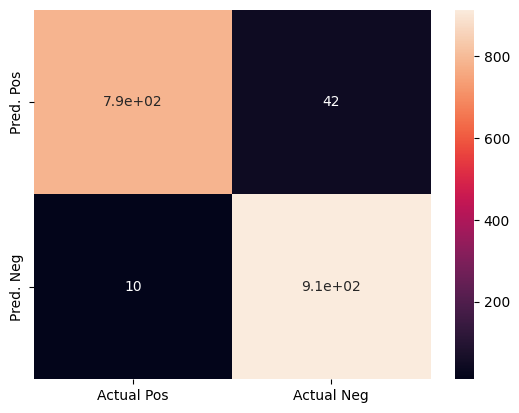

In [ ]:
## Plot Confusion Matrix
import seaborn as sns

def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])

## Confusion Matrix
from sklearn.metrics import confusion_matrix

#predict = search.predict(val_data_m1.drop(target, axis = 1))
confusion = confusion_matrix(val_data_m1[target], predict)
tp = confusion[1,1]
fp = confusion[0,1]
tn = confusion[0,0]
fn = confusion[1,0]

plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)

Prediction on Test Set

In [ ]:
#Test Prediction
predictions = search.predict(test_data_scaled)

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission1.csv', index=False)

## 5. 2nd Model - AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

Grid Search to find best AdaBoost params

In [ ]:
params = {"n_estimators": [25,50,100,125,150],
          "learning_rate": [0.05,0.1,0.5,1.0]}
abc = AdaBoostClassifier()
abc_gs = GridSearchCV(estimator=abc, param_grid=params, cv=6, return_train_score=True)
abc_gs.fit(train_data_m1.drop(target, axis = 1), train_data_m1[target])

GridSearchCV(cv=6, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.5, 1.0],
                         'n_estimators': [25, 50, 100, 125, 150]},
             return_train_score=True)

Train model with best params

In [ ]:
best_abc = abc_gs.best_estimator_
abc_pred = best_abc.predict(val_data_m1.drop(target, axis = 1))

In [ ]:
print(best_abc)

AdaBoostClassifier(learning_rate=0.1, n_estimators=150)


### Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

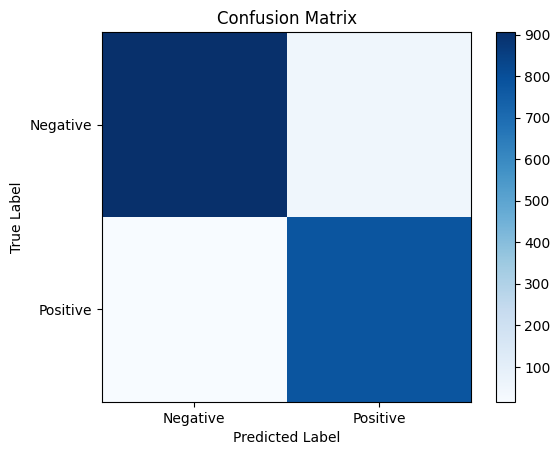

In [ ]:
cm = confusion_matrix(val_data_m1[target], abc_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(2), ["Negative", "Positive"])
plt.yticks(np.arange(2), ["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


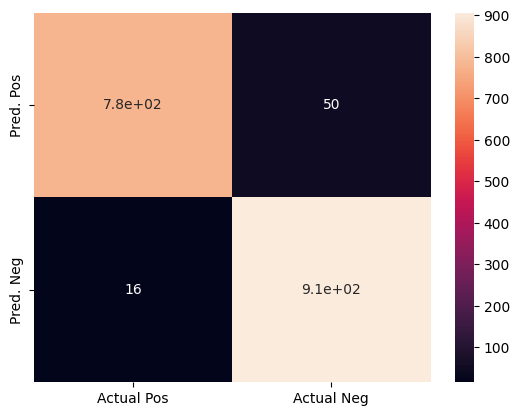

In [ ]:
tp = cm[1,1]
fp = cm[0,1]
tn = cm[0,0]
fn = cm[1,0]

plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)

In [ ]:
pred = best_abc.predict(test_data_scaled)

to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = pred
to_save.to_csv('submission2.csv', index=False)

## 6. Using Lasso to detact the most important feature for the prediction

In [ ]:
from sklearn.linear_model import Lasso
X_train = train_data_m1.drop(target, axis = 1)
y_train = train_data_m1[target]
# Assuming X_train and y_train are your training data
model = Lasso(alpha=0.1)  # Set the regularization parameter alpha
model.fit(X_train, y_train)

# Get the feature coefficients
coefficients = model.coef_

# Get the feature names
feature_names = X_train.columns

# Create a dictionary mapping feature names to their coefficients
feature_coefficients = dict(zip(feature_names, coefficients))

# Rank the features based on their absolute coefficient values
feature_importance_ranking = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the ranked features and their coefficients
for feature, coefficient in feature_importance_ranking:
    print(f"{feature}: {coefficient}")

nchapters: 0.2075215954212428
ndays_act: 0.1324930333844306
registered: 0.0
viewed: 0.0
explored: 0.0
YoB: 0.0
nevents: 0.0
nplay_video: 0.0
nforum_posts: 0.0
final_cc_cname_DI_Australia: 0.0
final_cc_cname_DI_Bangladesh: -0.0
final_cc_cname_DI_Brazil: -0.0
final_cc_cname_DI_Canada: 0.0
final_cc_cname_DI_China: 0.0
final_cc_cname_DI_Colombia: 0.0
final_cc_cname_DI_Egypt: -0.0
final_cc_cname_DI_France: 0.0
final_cc_cname_DI_Germany: 0.0
final_cc_cname_DI_Greece: 0.0
final_cc_cname_DI_India: 0.0
final_cc_cname_DI_Indonesia: -0.0
final_cc_cname_DI_Japan: -0.0
final_cc_cname_DI_Mexico: -0.0
final_cc_cname_DI_Morocco: -0.0
final_cc_cname_DI_Nigeria: 0.0
final_cc_cname_DI_Other Africa: 0.0
final_cc_cname_DI_Other East Asia: -0.0
final_cc_cname_DI_Other Europe: 0.0
final_cc_cname_DI_Other Middle East/Central Asia: 0.0
final_cc_cname_DI_Other North & Central Amer., Caribbean: -0.0
final_cc_cname_DI_Other Oceania: -0.0
final_cc_cname_DI_Other South America: -0.0
final_cc_cname_DI_Other South As

**Remember to submit your submissions CSV FILE on Kaggle!** 40 pts come from your accuracy on the private test data.

Attend section on Thurs 5/11 for a demo of how to uppload submissions to Kaggle. We also have screenshots below (ingore summer and homework number in pictures)

Step 1: See the list of files on Colab

![See Colab Files](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/1_colab_see_files.jpg)

Step 2: Download `submission.csv`

![Download Colab File](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/2_colab_download_file.jpg)

Step 3: Join the Kaggle competition.

![Join the Kaggle Competition](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/3_kaggle_join_competition.jpg)

Step 4: Enusre your team name in Kaggle matches the one at the top of this notebook!

![Check Team Name](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/4_kaggle_team_name.jpg)

Step 5: Upload `submission.csv` to Kaggle

![Upload submission.csv](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/6_kaggle_upload_submission.jpg)



### **Discussion**



#### **[7 Pts] Training the Models**

**Instructions**: Discuss what models you tried, and what you did to improve your initial predictions. Discuss what hyperparameters you tried, and which hyperparameters seemed important for your final model. Finally, discuss what you are inferring from the above visualiation(s).

The two models we tried for this assignments are the Random Forest Classifier and the AdaBoost Classifier.

For our first try (RFC), we tried a combination of n_estimators being 20, 50, 150, 250, 300 and
max_depth being 2, 5, 10, 15, 20, with the best sets of parameters being n_estimators = 250 and max_depth = 15. Both the n_estimators and max_depth are important hyperparameters for this particular model. The number of estimators determines the total number of trees, which creates a tradeoff between speed and accuracy (more trees means more accurate predictions but more runtime). The maximum depth is crucial since it can effectively prevent the model from overfitting.

For the second method (AdaBoost), we tried n_estimators being 25,50,100,125,150 and learning_rate being 0.05,0.1,0.5,1.0; we found the best combination to be when n_estimators=150 and learning_rate=0.5. Similar to the Random Forest Classifier, the number of estimators is also important in the AdaBoost model as it determines the number of weak learners. Learning rate is another important hyperparameter here because it controls the weight of the base model.

By examining the confusion matrices from both models, we can see that they both did a descent job. The first model has a precision of 0.950, a recall of 0.988, and an accuracy of 0.973, while the second model has a precision of 0.944, a recall of 0.976, and an accuracy of 0.964.

#### **[3 Pts] Feature Selection**

**Instructions**: Discuss what features you used and whether you did some transformations on them. What features seemed important for your final model?

The nchapters is the feature that is most important for predicting the data, since in LASSO with regularization parameter of 0.1 we get the largest value for this feature. Also, the nchapters, ndays_act,
registered, viewed, explored, YoB, nevents, nplay_video, nforum_posts, final_cc_cname_DI, LoE_DI, gender, course_id are important features in the model, since we used those features to train the modle and a good performance on the data.

#### **[5 Pts] Ethical Implications**

**Instructions**: Consider and discuss the ethical implications of using the model you trained. Imagine you were hired to work as a data scientist for an online education platform (exciting, right?). They want to use your model to predict which students they should tailor their course material towards so they can maximize their profits. Their idea is to use the model to help predict which student groups (i.e. from specific countries or certain educational backgrounds) would make them the most money by getting the most participants to complete their paid certificate program. Are there any ethical considerations we should think about before acting on that plan?

There are some ethical issues about our model:
1. Since we did not process the row data too much, it is possible that we break the fairness. People from certain groups tend to be accepted more than people from other groups.
2. Since we are focusing on profit maximization, we overlook the students who need educational support more than others. From an ethical view, we need to give support to all people.

Also, we solved some issues:
1.	We made our estimate transparent. We specifies which features are important on deciding who can make more profit and acquired.
2.	Also, we made data secured. Student data cannot be accessed by others since it is only used for training the model and not used by other purpose.
